In [1]:
#https://www.tensorflow.org/hub/tutorials/tf2_image_retraining
import itertools
import os
import shutil

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import json
import kerastuner as kt
import PIL

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
GOOD = 0
BAD = 1

In [3]:
#read data
train_data_dir = "/home/jupyter/large-dataset/medium-dataset/training"
val_data_dir = "/home/jupyter/large-dataset/medium-dataset/validation"
train_data=[]
train_labels=[]
train_imagePaths = []
for label in os.listdir(train_data_dir):
    listdir = os.listdir(os.path.sep.join([train_data_dir,label]))
    if label == 'Good':
        bin_label = GOOD
    elif label == 'Bad':
        bin_label = BAD
    for filename in listdir:
        imagePath = os.path.sep.join([train_data_dir,label, filename])
        image = load_img(imagePath, target_size=IMAGE_SIZE)
        image = img_to_array(image) / 255.0
        train_data.append(image)
        train_labels.append(bin_label)
        train_imagePaths.append(imagePath)
train_data = np.array(train_data)
train_labels = np.array(train_labels)
train_imagePaths = np.array(train_imagePaths)

In [4]:
val_data=[]
val_labels=[]
val_imagePaths = []
for label in os.listdir(val_data_dir):
    listdir = os.listdir(os.path.sep.join([val_data_dir,label]))
    if label == 'Good':
        bin_label = GOOD
    elif label == 'Bad':
        bin_label = BAD
    for filename in listdir:
        imagePath = os.path.sep.join([val_data_dir,label, filename])
        image = load_img(imagePath, target_size=IMAGE_SIZE)
        image = img_to_array(image) / 255.0
        val_data.append(image)
        val_labels.append(bin_label)
        val_imagePaths.append(imagePath)
val_data = np.array(val_data)
val_labels = np.array(val_labels)
val_imagePaths = np.array(val_imagePaths)

In [5]:
test_data_dir = "/home/jupyter/large-dataset/test-data-large"
test_data=[]
test_labels=[]
test_imagePaths = []
for label in os.listdir(test_data_dir):
    listdir = os.listdir(os.path.sep.join([test_data_dir,label]))
    if label == 'Good':
        bin_label = GOOD
    elif label == 'Bad':
        bin_label = BAD
    for filename in listdir:
        imagePath = os.path.sep.join([test_data_dir,label, filename])
        image = load_img(imagePath, target_size=IMAGE_SIZE)
        image = img_to_array(image) / 255.0
        test_data.append(image)
        test_labels.append(bin_label)
        test_imagePaths.append(imagePath)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_imagePaths = np.array(test_imagePaths)

In [6]:
#model
vgg = VGG16(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
head = tf.keras.layers.Dropout(rate=0.7)(vgg.output)
x = GlobalAveragePooling2D()(head)
x = BatchNormalization()(x)
x = Dropout(0.0)(x)
x = Dense(1024,activation='relu')(x) 
x = Dense(512,activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
head = tf.keras.layers.Dense(1, activation = 'sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001), name="class_label")(x)
model = Model(
    inputs=vgg.input,
    outputs=(head))
for layer in model.layers[:11]:
    layer.trainable = False
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()
model.compile(
  optimizer = tf.keras.optimizers.Adam(lr=0.0001), 
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
#training
steps_per_epoch = len(train_data) // BATCH_SIZE
validation_steps = len(val_data) // BATCH_SIZE
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)
hist = model.fit(
    train_data, train_labels,
    epochs=50, steps_per_epoch=steps_per_epoch,
    validation_data=(val_data, val_labels),
    validation_steps=validation_steps, callbacks=[callback]).history

Epoch 1/50
16/16 [==============================] - 30s 1s/step - loss: 0.8367 - accuracy: 0.5975 - auc: 0.6686 - precision: 0.3400 - recall: 0.6272 - val_loss: 0.6966 - val_accuracy: 0.4769 - val_auc: 0.8610 - val_precision: 0.3585 - val_recall: 1.0000
Epoch 2/50
16/16 [==============================] - 7s 444ms/step - loss: 0.7265 - accuracy: 0.7050 - auc: 0.8008 - precision: 0.4809 - recall: 0.7573 - val_loss: 0.9640 - val_accuracy: 0.2923 - val_auc: 0.8736 - val_precision: 0.2923 - val_recall: 1.0000
Epoch 3/50
16/16 [==============================] - 7s 443ms/step - loss: 0.5717 - accuracy: 0.7774 - auc: 0.9058 - precision: 0.5416 - recall: 0.8910 - val_loss: 1.3406 - val_accuracy: 0.2923 - val_auc: 0.8793 - val_precision: 0.2923 - val_recall: 1.0000
Epoch 00003: early stopping


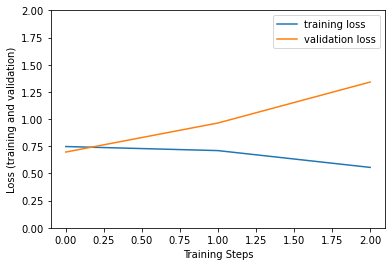

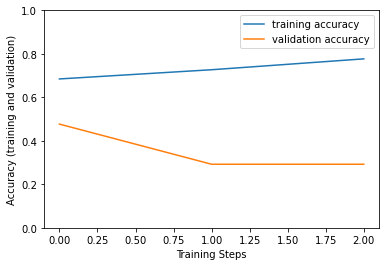

In [8]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], label='training loss')
plt.plot(hist["val_loss"], label='validation loss')
plt.legend()

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], label='training accuracy')
plt.plot(hist["val_accuracy"], label='validation accuracy')
plt.legend()

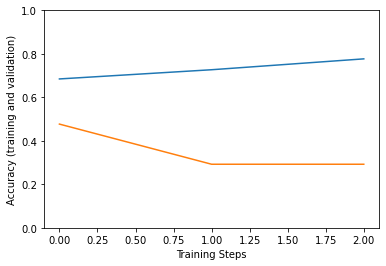

In [9]:
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [10]:
#https://www.tensorflow.org/tutorials/keras/save_and_load?fbclid=IwAR3JVn-_CLqgNuKO3G92cMYCNqVL81oxVs3bP6QhfgFLPiE4VbEMK2QQffc
loss, acc, auc, precision, recall = model.evaluate(test_data, test_labels, verbose=2)

4/4 - 16s - loss: 1.3817 - accuracy: 0.2551 - auc: 0.8838 - precision: 0.2551 - recall: 1.0000


In [14]:
i=0
while i < len(test_data):
    x = np.expand_dims(test_data[i], axis=0)
    pred = model.predict(x)
    p = (pred[0][0] > 0.5).astype(np.int)
    if p==0:
        predicted_label = 'Good'
    elif p==1:
        predicted_label = 'Bad'
    print(predicted_label + ", actual: "+str(test_labels[i]))
    i+=1

Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actual: 0
Bad, actua

In [15]:
saved_model_path = "/home/jupyter/SmallMediumModels/VGG-MediumDataModel"
tf.saved_model.save(model, saved_model_path)
model.save('VGG-MediumDatasetModel.h5')

INFO:tensorflow:Assets written to: /home/jupyter/SmallMediumModels/VGG-MediumDataModel/assets
